<a href="https://colab.research.google.com/github/erfunmirzaei/Social_Bandit/blob/main/Social_Bandit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import csv
import json
import matplotlib.pyplot as plt
import random
import gym
from math import sqrt
from scipy.stats import t
from statistics import mean
from tqdm import tqdm
from abc import ABC, abstractmethod

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Implementations

## Rewards

In [2]:
class MultinomialReward():
    def __init__(self, rewards, probs):
        """
        rewards: a list of rewards are given by an specific arm
        probs: a list of probabilities correspondant to each reward in rewards list
        """
        self.rewards = rewards
        self.probs = probs
        self.mean = np.array(probs) @ np.array(rewards)        

    def get_reward(self, t):
        return random.choices(self.rewards, weights = self.probs, k = 1)[0]

In [3]:
class DeteriministicReward():
    def __init__(self, reward):
        """
        rewards: a list of rewards are given by a specific arm
        """
        self.reward = reward
        self.mean = reward
        
    def get_reward(self, t):
        return self.reward

In [4]:
class GaussianReward():
    def __init__(self, mean, std):
        """
        mean: a float shows the mean of gaussian distribution related to reward are given by a specific arm 
        std: a float shows the standard deviation of gaussian distribution related to reward are given by a specific arm
        """
        self.mean = mean
        self.std = std

    def get_reward(self, t):
        return np.random.normal(loc=self.mean, scale=self.std)

In [5]:
class Students_t_distReward():
    def __init__(self,dof, mean, std):
        """
        dof: an integer shows degree of freedom for t-distribution
        mean: a float shows the mean of gaussian distribution related to reward are given by a specific arm 
        std: a float shows the standard deviation of gaussian distribution related to reward are given by a specific arm
        """
        self.dof = dof
        self.mean = mean
        self.std = std

    def get_reward(self, t):
        return t.rvs(df = self.dof, loc=self.mean, scale=self.std)

In [6]:
class MultinomialReward_NonStationary():
    def __init__(self, rewards, probs, switch_t):
        """
        rewards: a list of rewards are given by an specific arm
        probs: a list of probabilities correspondant to each reward in rewards list
        switch_t: an integer determine the swtich time
        """
        self.rewards = rewards
        self.probs = probs
        self.mean = np.array(probs) @ np.array(rewards)  
        self.switch_t = switch_t

    def get_reward(self, t):
        if t < self.switch_t:
            return random.choices(self.rewards, weights = self.probs, k = 1)[0]
        
        else:
            return random.choices(self.rewards[::-1], weights = self.probs, k = 1)[0]

## N-Armed Bandit Environments

In [7]:
class MutliArmedBanditEnvironment():
    def __init__(self, rewards, episode_max_length, id = None, container=None):
        """
        rewards: a list of reward object, length = number of arms
        episode_max_length: maximum length of each episode 
        id: id of environment
        container: 
        """
        state_space = gym.spaces.Discrete(1)
        action_space = gym.spaces.Discrete(len(rewards))

        self.action_space = action_space
        self.observation_space = state_space
        self.state = None
        self.id = id
        self.agents = {}
        
        if container != None:
            container.register_environment(self)
        self.arms_rewards = rewards # consits all rewards method
        self.episode_max_length = episode_max_length
        self.state = {
            'length': 0,
            'last_action': None
        }

    def add_agent(self, agent_id):
        self.agents_last_choice[agent_id] = -1 
        
    def calculate_reward(self, action):
        return self.arms_rewards[action].get_reward(self.state['length'])

    def terminated(self):
        return self.state['length'] >= self.episode_max_length

    def observe(self):
        return {}

    def n_actions(self):
        return self.action_space.n

    def next_state(self, action):
        self.state['length'] += 1
        self.state['last_action'] = action
    
    def get_info(self):
        return {} 

    def update_selected(self, action, agent_id):
        if agent_id == -1:
            return
        self.agents_last_choice[agent_id] = action

    def step(self, action, agent_id):
        reward = self.calculate_reward(action)
        observation = self.observe()
        info = self.get_info()
        self.next_state(action)
        done = self.terminated()
        self.update_selected(action, agent_id) #agent_id == -1 ==> do nothing
        return observation, reward, done, info

    def reset(self):
        self.state['length'] = 0
        self.state['last_action'] = None

    def render(self, mode='human'):
        print('{}:\taction={}'.format(self.state['length'], self.state['last_action']))

    def close(self):
        return

In [8]:
class SocialMutliArmedBanditEnvironment():
    def __init__(self, rewards, episode_max_length, id = None, container = None):
        """
        rewards: a list of reward object, length = number of arms
        episode_max_length: maximum length of each episode 
        id: id of environment
        container: 
        """
        self.observation_space = gym.spaces.Discrete(1)
        self.action_space = gym.spaces.Discrete(len(rewards))
        
        if container != None:
            container.register_environment(self)

        self.id = id
        self.arms_rewards = rewards
        self.agents_last_choice = {}
        self.episode_max_length = episode_max_length
        # self.optimal_action = np.argmax(R_mean)

        self.state = {
            'length': 0,
            'last_action': None
        }
    
    def add_agent(self, agent_id):
        self.agents_last_choice[agent_id] = -1 
     
    def calculate_reward(self, action):
        return self.arms_rewards[action].get_reward(self.state['length'])
    
    def update_selected(self, action, agent_id):
        if agent_id == -1:
            return
        self.agents_last_choice[agent_id] = action
        
    
    def terminated(self):
        return self.state['length'] >= self.episode_max_length

    def observe(self):
        return {}
    
    def n_actions(self):
        return self.action_space.n

    def next_state(self, action):
        self.state['length'] += 1
        self.state['last_action'] = action
    
    def get_info(self):
        return {} 

    def step(self, action, agent_id):
        reward = self.calculate_reward(action)
        observation = self.observe()
        info = self.get_info()
        self.next_state(action)
        done = self.terminated()
        self.update_selected(action, agent_id) #agent_id == -1 ==> do nothing
        return observation, reward, done, info
    
    def config(self):
        self.agents_last_choice = []
    
    def reset(self):
        self.state['length'] = 0
        self.state['last_action'] = None

    def render(self, mode='human'):
        print('{}:\taction={}'.format(self.state['length'], self.state['last_action']))

    def close(self):
        return

## Agents 

In [9]:
class AgentBase:
    def __init__(self, environment = None, id = None, alpha = 1,beta = 1,gamma = 1,
                 lr = 0.1, lr_decay = 1):
        """
        environment: the env object that agent interact with it
        id: an int, the number of agent, used as a key in agents dict in environment
        alpha, beta, gamma: float numbers are used for measuring utility based on prospect theory
        lr = a float number, determine the rate of learning
        lr_decay = a float number, determine the decay of learning rate 
        """
        self.environment = environment
        self.id = id
        self.alpha = alpha
        self.beta = beta 
        self.gamma = gamma
        self.lr = lr
        self.lr_decay = lr_decay
        if id is not None:
            self.environment.add_agent(id)

    def set_environment(self, env):
        self.environment = env

    @abstractmethod
    def take_action(self) -> (object, float, bool, object):
        # in this method, you MUST call the `step` method of 
        # the environment and observe the results and return them like:
        # return observation, reward, done, info
        pass
    
    def utility_function(self,reward):
        if reward >= 0 :
            u = reward ** self.alpha
        else:
            u =  -1 * self.gamma * ((-reward)** self.beta)
        return u 

### Learner Agents

In [10]:
class EpsilonGreedyAgent(AgentBase): 
    def __init__(self, environment = None, id = None, alpha = 1, beta = 1, gamma = 1, lr = None,
                 lr_decay = 1, epsilon = 0.1, epsilon_decay = 1,  optimistic = False):
        """
        environment: the env object that agent interact with it
        id: String or float or int, the name or the number of agent, used as a key in agents dict in environment
        alpha, beta, gamma: float numbers are used for measuring utility based on prospect theory
        lr = a float number, determine the rate of learning
        lr_decay = a float number, determine the decay of learning rate 
        epsilon = a float number, determine degree of exploration
        epsilon_decay = a float number, determine degree of decaying epsilon
        optimistic = a bool, determine using optimistic initialization
        """
        #Add Temperature
        super(EpsilonGreedyAgent, self).__init__(environment, id, alpha, beta, gamma, lr, lr_decay)
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        if environment is not None:
            self.n_actions = self.environment.n_actions()
            
            self.Q = np.zeros((self.n_actions,1))     #action value fuction
            self.N = np.zeros((self.n_actions,1))     #number of doing an action 

    def get_number_actions(self):
        return self.N
    
    def set_environment(self, env):
        self.environment = env
        self.n_actions = self.environment.n_actions()

        self.Q = np.zeros((self.n_actions,1))     #action value fuction
        self.N = np.zeros((self.n_actions,1))     #number of doing an action 

    def update(self, action, utility):
        self.epsilon = self.epsilon * self.epsilon_decay
        self.N[action] += 1
        if self.lr is not None:
            self.Q[action] += (utility - self.Q[action]) * self.lr
            self.lr = self.lr * self.lr_decay 
        else:
            self.Q[action] += (utility - self.Q[action])/self.N[action] 

    def select_action(self):
        rand = np.random.rand()
        if rand < self.epsilon:
            action = np.random.choice(self.n_actions)
        else:
            action = np.argmax(self.Q)
        
        return action

    def take_action(self) -> (object, float, bool, object):
        if self.environment is None:
            raise("Env is not defined",)
        action = self.select_action()
        obs, r, d, i = self.environment.step(action, self.id)
        u = self.utility_function(r)
        self.update(action,u)
        
        return r, action , u

    def get_Q(self):
        return self.Q

In [11]:
class UCBAgent(AgentBase):
    def __init__(self, c, environment = None, id = None, alpha = 1, beta = 1, gamma = 1,
                 lr = None, lr_decay = 1,):
        """
        c: a float, determine the degree of exploration 
        environment: the env object that agent interact with it
        id: String or float or int, the name or the number of agent, used as a key in agents dict in environment
        alpha, beta, gamma: float numbers are used for measuring utility based on prospect theory
        lr = a float number, determine the rate of learning
        lr_decay = a float number, determine the decay of learning rate 
        """
        super(UCBAgent, self).__init__(environment, id, alpha, beta, gamma, lr, lr_decay)
        self.c = c
        self.trial = 0                                          #number of total trials 

        if environment is not None:
            self.n_actions = self.environment.n_actions()
            self.Q = np.zeros((self.n_actions,1))                 #action value function(expected reward) for each arm
            self.N = np.zeros((self.n_actions,1))                 #number of doing each arm
            self.UCB = np.inf * np.ones((self.n_actions,1))      #Upper confidence bound for each arm
            
    def select_action(self):        
        action = np.random.choice(np.flatnonzero(self.UCB == self.UCB.max()))
        return action 

    def set_environment(self, env):
        self.environemnt = env
        self.n_actions = self.environment.n_actions()
        self.Q = np.zeros((self.n_actions,1))                 #action value function(expected reward) for each arm
        self.N = np.zeros((self.n_actions,1))                 #number of doing each arm
        self.UCB = np.inf * np.ones((self.n_actions,1))      #Upper confidence bound for each arm

    def update(self, action, u):        
        # update action values
        self.trial += 1
        self.N[action] = self.N[action] + 1
        if self.lr is not None:
            self.Q[action] += self.lr*(u-self.Q[action])
            self.lr = self.lr * self.lr_decay
        else:
            self.Q[action] += (u-self.Q[action]) / self.N[action]

        self.UCB = self.Q + self.c * np.sqrt(np.log(self.trial)/(self.N + 1e-9))

        
    def take_action(self) -> (object, float, bool, object):
        if self.environment is None:
            raise("Env is not defined")
        action = self.select_action()
        obs, r, d, i = self.environment.step(action, self.id)
        u = self.utility_function(r)
        self.update(action, u)
        return r, action, u

In [12]:
class GradientBanditAgent(AgentBase): 
    def __init__(self, environment = None, id = None, alpha = 1, beta = 1, gamma = 1,
                 lr = 0.1, lr_decay = 1, optimistic = False, Baseline_lr = None):
        """
        environment: the env object that agent interact with it
        id: String or float or int, the name or the number of agent, used as a key in agents dict in environment
        alpha, beta, gamma: float numbers are used for measuring utility based on prospect theory
        lr = a float number, determine the rate of learning
        lr_decay = a float number, determine the decay of learning rate 
        optimistic = a bool, determine using optimistic initialization
        baseline_lr: a float number, determine the rate of updating the baseline
        """
        super(GradientBanditAgent, self).__init__(environment, id, alpha, beta, gamma, lr, lr_decay)

        self.R_lr = Baseline_lr
        self.avg_rew = 0   
        self.N = 0      
        if environment is not None:
            self.n_actions = self.environment.n_actions()
            self.H = np.zeros((self.n_actions))
            self.P = (1/self.n_actions)*np.ones((self.n_actions))
    
    def set_environment(self, env):
        self.environment = env
        self.n_actions = self.environment.n_actions()
        self.H = np.zeros((self.n_actions))
        self.P = (1/self.n_actions)*np.ones((self.n_actions))       

    def update(self, action, utility):
        self.lr = self.lr * self.lr_decay
        self.N += 1
        if self.R_lr is not None:
            self.avg_rew += (utility - self.avg_rew) * self.R_lr
        else:
            self.avg_rew += (utility - self.avg_rew)/self.N

        for i in range(len(self.H)):
            if i == action :
                self.H[i] += self.lr *(utility - self.avg_rew)*(1-self.P[i])

            else:
                self.H[i] -=  self.lr *(utility - self.avg_rew)*(self.P[i])

        for i in range(len(self.P)):
            self.P[i] = np.exp(self.H[i]) / np.sum(np.exp(self.H))

    def get_all(self):
        return self.H,self.P

    def select_action(self):
        action = int(np.random.choice(list(range(self.n_actions)), size=1,p=self.P))       
        return action 

    def take_action(self) -> (object, float, bool, object):
        if self.environment is None:
            raise("Env is not defined",)
        action = self.select_action()
        obs, r, d, i = self.environment.step(action, self.id)
        #(obs, r, d, i)
        u = self.utility_function(r)
        self.update(action,u)
        #self.environment.render()
        return r, action , u


In [13]:
class ActorCriticAgent(AgentBase): 
    def __init__(self, environment = None, id = None, alpha = 1, beta = 1, gamma = 1,
                 lr = 0.1, lr_decay = 1, optimistic = False):
        """
        environment: the env object that agent interact with it
        id: String or float or int, the name or the number of agent, used as a key in agents dict in environment
        alpha, beta, gamma: float numbers are used for measuring utility based on prospect theory
        lr = a float number, determine the rate of learning
        lr_decay = a float number, determine the decay of learning rate 
        optimistic = a bool, determine using optimistic initialization
        """
        super(ActorCriticAgent, self).__init__(environment, id, alpha, beta, gamma, lr, lr_decay)
        self.N = 0      
        if environment is not None:
            self.n_actions = self.environment.n_actions()
            self.Q = np.zeros((self.n_actions))     #action value fuction
            self.H = np.zeros((self.n_actions))
            self.P = (1/self.n_actions)*np.ones((self.n_actions))
    
    def set_environment(self, env):
        self.environment = env
        self.n_actions = self.environment.n_actions()
        self.Q = np.zeros((self.n_actions))     #action value fuction
        self.H = np.zeros((self.n_actions))
        self.P = (1/self.n_actions)*np.ones((self.n_actions))        

    def update(self,action,utility):
        self.lr = self.lr * self.lr_decay
        self.N += 1
        if self.lr is not None:
            self.Q[action] += (utility - self.Q[action]) * self.lr
            self.lr = self.lr * self.lr_decay 
        else:
            self.Q[action] += (utility - self.Q[action])/self.N[action] 

        for i in range(len(self.H)):
            if i == action :
                self.H[i] += self.lr *(utility - self.Q[i])*(1-self.P[i])

            else:
                self.H[i] -=  self.lr *(utility - self.Q[i])*(self.P[i])

        for i in range(len(self.P)):
            self.P[i] = np.exp(self.H[i]) / np.sum(np.exp(self.H))

    def get_all(self):
        return self.H,self.P

    def select_action(self):
        action = int(np.random.choice(list(range(self.n_actions)), size=1,p=self.P))  
        return action

    def take_action(self) -> (object, float, bool, object):
        if self.environment is None:
            raise("environment is not defined")
        action = self.select_action()
        obs, r, d, i = self.environment.step(action, self.id)
        #print(obs, r, d, i)
        u = self.utility_function(r)
        self.update(action,u)
        #self.environment.render()
        return r, action , u

In [14]:
class ThompsonSamplingAgent(AgentBase):
    def __init__(self, environment = None, id = None, alpha = 1, beta = 1, gamma = 1,
                 lr = 0.1, lr_decay = 1):
        """
        environment: the env object that agent interact with it
        id: String or float or int, the name or the number of agent, used as a key in agents dict in environment
        alpha, beta, gamma: float numbers are used for measuring utility based on prospect theory
        lr = a float number, determine the rate of learning
        lr_decay = a float number, determine the decay of learning rate 
        """
        super(ThompsonSamplingAgent, self).__init__(environment, id, alpha, beta, gamma, lr, lr_decay)
        
        if self.environment is not None:
            self.n_actions = self.environment.n_actions()
            self.stds = list(1000000000 * np.ones((self.n_actions,1)))  #stds of estimated gaussian distributions
            self.means = list( np.zeros((self.n_actions,1)))            #means of estimated gaussian distributions

    def set_environment(self, env):
        self.environment = env 
        self.n_actions = self.environment.n_actions()
        self.stds = list(1000000000 * np.ones((self.n_actions,1)))  #stds of estimated gaussian distributions
        self.means = list( np.zeros((self.n_actions,1)))            #means of estimated gaussian distributions

    def get_samples(self,means,stds):
        samples = [np.random.normal(means[i],stds[i]) for i in range(len(means))]
        return samples

    def update(self, action, reward):
        new_std = sqrt( 1 / ((1/self.stds[action]**2) + 1) )
        new_mean = (reward + (self.means[action] / self.stds[action] ** 2)) / ((1/self.stds[action]**2) + 1) 
        self.means[action] = new_mean
        self.stds[action] = new_std
        return 

    def select_action(self):
        samples = self.get_samples(self.means,self.stds)
        action = np.argmax(samples)
        return action 

    def take_action(self):# -> (object, float, bool, object):
        if self.environment is None:
            raise("Env is not defined",)
        action = self.select_action()
        obs, r, d, i = self.environment.step(action, self.id)
        u = self.utility_function(r)
        self.update(action, u)
        #print(obs, r, d, i)
        #self.environment.render()
        return r,action, u

### Coded Agents:

In [15]:
class AlwaysBestAgent(AgentBase):
    def __init__(self, environment = None, id = None, alpha = 1, beta = 1, gamma = 1):
        """
        environment: the env object that agent interact with it
        id: String or float or int, the name or the number of agent, used as a key in agents dict in environment
        alpha, beta, gamma: float numbers are used for measuring utility based on prospect theory
        """
        super(AlwaysBestAgent, self).__init__(environment, id, alpha, beta, gamma)
        if self.environment is not None:
            self.EU = np.array([self.utility_function(r.mean) for r in self.environment.arms_rewards])
            self.bestaction = np.random.choice(np.flatnonzero(self.EU == self.EU.max()))
        # self.regret = []
    
    def set_environment(self, env):
        self.environment = env 
        self.EU = np.array([self.utility_function(r.mean) for r in self.environment.arms_rewards])
        self.bestaction = np.random.choice(np.flatnonzero(self.EU == self.EU.max())) 
           
    def take_action(self):
        if self.environment is None:
            raise("environment is not defined")
        obs, r, d, i = self.environment.step(self.bestaction, self.id)
        #self.r = self.r + self.environment.rewards[np.argmax([r.m for r in self.environment.rewards])].m - self.environment.rewards[indx].mean
        #self.regret.append(self.r)
        return r, self.bestaction, self.utility_function(r)

In [16]:
class PercentBestAgent(AgentBase):
    def __init__(self, p, environment = None, id = None, alpha = 1, beta = 1, gamma = 1, 
                 increase = 0, limit = 1, zero_at = False):
        """
        p: a float number between 0 and 1, determine the proportion of selecting the optimal arm
        environment: the env object that agent interact with it
        id: String or float or int, the name or the number of agent, used as a key in agents dict in environment
        alpha, beta, gamma: float numbers are used for measuring utility based on prospect theory
        increase: a float number between 0 and 1, determine the amount of selecting the optimal arm
        limit: a float number between 0 and 1, determine the upper bound of selecting the optimal arm
        zero_at: a bool, determine that we revert the selecting probability to zero after reaching to one 
        """
        super(PercentBestAgent, self).__init__(environment, id, alpha, beta, gamma)
        self.p = p
        self.increase = increase
        self.zero_at = zero_at
        self.limit = limit
        if self.environment is not None:
            self.EU = np.array([self.utility_function(r.mean) for r in self.environment.arms_rewards])
            self.bestaction = np.random.choice(np.flatnonzero(self.EU == self.EU.max()))
            self.n_actions = self.environment.n_actions()
            # self.regret = []
    
    def set_environment(self, env):
        self.environment = env
        self.EU = np.array([self.utility_function(r.mean) for r in self.environment.arms_rewards])
        self.bestaction = np.random.choice(np.flatnonzero(self.EU == self.EU.max()))
        self.n_actions = self.environment.n_actions() 

    def take_action(self):
        if self.environment is None:
            raise("environment is not defined")
        
        if np.random.rand() < self.p:
            action = self.bestaction
        else:
            action = np.random.choice(self.n_actions)
        
        obs, r, d, i = self.environment.step(action, self.id)

        #self.r = self.r + self.environment.rewards[np.argmax([r.m for r in self.environment.rewards])].m - self.environment.rewards[indx].m
        #self.regret.append(self.r)

        self.p = self.p + self.increase
        if self.p > self.limit:
            self.p = self.limit
            self.increase = 0
            
        if self.zero_at:
            if self.p > 1:
                self.p = 0
                self.increase = 0
        return r, action, self.utility_function(r)
        

In [17]:
class SecondBestAgent(AgentBase):
    def __init__(self, environment = None, id = None, alpha = 1, beta = 1, gamma = 1):
        """
        environment: the env object that agent interact with it
        id: String or float or int, the name or the number of agent, used as a key in agents dict in environment
        alpha, beta, gamma: float numbers are used for measuring utility based on prospect theory
        """
        super(SecondBestAgent, self).__init__(environment, id, alpha, beta, gamma)
        if self.environment is not None:
            self.EU = np.array([self.utility_function(r.mean) for r in self.environment.arms_rewards])
            SecondEU = np.array([x for x in self.EU if x < max(self.EU)])
            self.secondbestaction = np.random.choice(np.flatnonzero(self.EU == SecondEU.max()))
            # self.regret = []

    def take_action(self):
        obs, r, d, i = self.environment.step(self.secondbestaction, self.id)
        return r, self.secondbestaction, self.utility_function(r)
    

In [18]:
class AlwaysWorstAgent(AgentBase):
    def __init__(self, environment = None, id = None, alpha = 1, beta = 1, gamma = 1):
        """
        environment: the env object that agent interact with it
        id: String or float or int, the name or the number of agent, used as a key in agents dict in environment
        alpha, beta, gamma: float numbers are used for measuring utility based on prospect theory
        """
        super(AlwaysWorstAgent, self).__init__(environment, id, alpha, beta, gamma)
        if self.environment is not None:
            self.EU = np.array([self.utility_function(r.mean) for r in self.environment.arms_rewards])
            self.worstaction = np.random.choice(np.flatnonzero(self.EU == self.EU.min()))
        # self.regret = []

    def set_environment(self, env):
        self.environment = env    
        self.EU = np.array([self.utility_function(r.mean) for r in self.environment.arms_rewards])
        self.worstaction = np.random.choice(np.flatnonzero(self.EU == self.EU.min()))
            
    def take_action(self):
        if self.environment is None:
            raise("environment is not defined")
        obs, r, d, i = self.environment.step(self.worstaction, self.id)
        return r, self.worstaction, self.utility_function(r)
    

In [19]:
class AlwaysRandomAgent(AgentBase):
    def __init__(self, environment = None, id = None, alpha = 1, beta = 1, gamma = 1):
        """
        environment: the env object that agent interact with it
        id: String or float or int, the name or the number of agent, used as a key in agents dict in environment
        alpha, beta, gamma: float numbers are used for measuring utility based on prospect theory
        """
        super(AlwaysRandomAgent, self).__init__(environment, id, alpha, beta, gamma)
        if self.environment is not None:
            self.n_actions = self.environment.n_actions()
            # self.regret = []

    def set_environment(self, env):
        self.environment = env 
        self.n_actions = self.environment.n_actions()

    def take_action(self):
        if self.environment is None:
            raise("environment is not defined")        
        action = np.random.choice(self.n_actions)
        obs, r, d, i = self.environment.step(action, self.id)
        return r, action, self.utility_function(r)

## Test I

### Test1_Learner Agents 

In [37]:
Multinomial_Rewards = {  '2arm_Hard' : [MultinomialReward_NonStationary([1,0],[0.9,0.1], switch_t = 1000),
                                        MultinomialReward_NonStationary([1,0],[0.8,0.2], switch_t = 1000)] ,
                       
                         '2arm_Med'  : [MultinomialReward_NonStationary([1,0],[0.9,0.1], switch_t = 1000),
                                        MultinomialReward_NonStationary([1,0],[0.5,0.5], switch_t = 1000)],
                       
                         '2arm_Easy' : [MultinomialReward_NonStationary([1,0],[0.9,0.1], switch_t = 1000),
                                        MultinomialReward_NonStationary([1,0],[0.1,0.9], switch_t = 1000)]} 

In [38]:
env = SocialMutliArmedBanditEnvironment(Multinomial_Rewards['2arm_Easy'], 10000)

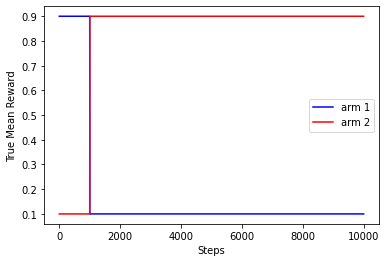

In [39]:
fig, ax = plt.subplots()
ax.plot(range(10000), np.array([0.9] * 1000 + [0.1] * 9000), 'b')
ax.plot(range(10000), np.array([0.1] * 1000 + [0.9] * 9000),'r')

ax.set_ylabel('True Mean Reward',rotation = 90)
ax.set_xlabel('Steps')
ax.legend(["arm 1", "arm 2"])
plt.show()

In [40]:
env.reset()
regret1 = np.zeros((10000,50))
perc_opt_act1 = np.zeros((10000,50))
average_rewards1 = np.zeros((10000,50))

for r in tqdm(range(50)):
    sum_rewards = 0
    opt_act_count = 0
    exp_opt_act = 0.9    
    agent1 = EpsilonGreedyAgent(environment = env, epsilon = 0.1, lr = 0.1)
    
    for t in range(10000):
        rew , act, _ = agent1.take_action()

        sum_rewards += rew
        
        if t < 1000:
            opt_act_count += int(act == 0)
            regret1[t,r] = (t+1)*exp_opt_act - sum_rewards

        else :
            opt_act_count += int(act == 1)
            exp_opt_act = 0.9
            regret1[t,r] = 1000 * 0.9 + (t+1 - 1000)*exp_opt_act - sum_rewards

        perc_opt_act1[t,r] = opt_act_count / (t+1)
        average_rewards1[t,r] = sum_rewards / (t+1)

    env.reset()

100%|██████████| 50/50 [00:15<00:00,  3.22it/s]


In [41]:
env.reset()
regret2 = np.zeros((10000,50))
perc_opt_act2 = np.zeros((10000,50))
average_rewards2 = np.zeros((10000,50))

for r in tqdm(range(50)):
    exp_opt_act = 0.9
    sum_rewards = 0
    opt_act_count = 0
    
    agent2 = UCBAgent(environment = env, c =2, lr = 0.1)
    # agent2 = UCBBanditAgent('1',env, c = 2, lr = 0.1)
    
    for t in range(10000):
        rew , act, _ = agent2.take_action()
        
        sum_rewards += rew
        
        if t < 1000:
            opt_act_count += int(act == 0)
            regret2[t,r] = (t+1)*exp_opt_act - sum_rewards

        else:
            opt_act_count += int(act == 1)
            exp_opt_act = 0.9
            regret2[t,r] = 1000 * 0.9 + (t+1 - 1000)*exp_opt_act - sum_rewards

        perc_opt_act2[t,r] = opt_act_count / (t+1)
        average_rewards2[t,r] = sum_rewards / (t+1)

    env.reset()

100%|██████████| 50/50 [00:48<00:00,  1.02it/s]


In [42]:
env.reset()
regret3 = np.zeros((10000,50))
perc_opt_act3 = np.zeros((10000,50))
average_rewards3 = np.zeros((10000,50))

for r in tqdm(range(50)):
    sum_rewards = 0
    opt_act_count = 0
    exp_opt_act = 0.9

    agent3 = ThompsonSamplingAgent(environment = env)
    
    for t in range(10000):
        rew , act, _ = agent3.take_action()
        
        sum_rewards += rew
        
        if t < 1000:
            opt_act_count += int(act == 0)
            regret3[t,r] = (t+1)*exp_opt_act - sum_rewards

        else :
            opt_act_count += int(act == 1)
            exp_opt_act = 0.9
            regret3[t,r] = 1000 * 0.9 + (t+1 - 1000)*exp_opt_act - sum_rewards

        perc_opt_act3[t,r] = opt_act_count / (t+1)
        average_rewards3[t,r] = sum_rewards / (t+1)

    env.reset()

100%|██████████| 50/50 [00:40<00:00,  1.25it/s]


In [43]:
env.reset()
regret4 = np.zeros((10000,50))
perc_opt_act4 = np.zeros((10000,50))
average_rewards4 = np.zeros((10000,50))

for r in tqdm(range(50)):
    sum_rewards = 0
    opt_act_count = 0
    exp_opt_act = 0.9
    
    agent4 = GradientBanditAgent(environment = env)
    
    for t in range(10000):
        rew , act, _ = agent4.take_action()
        sum_rewards += rew
        
        if t < 1000:
            opt_act_count += int(act == 0)
            regret4[t,r] = (t+1)*exp_opt_act - sum_rewards
        
        else :
            opt_act_count += int(act == 1)
            exp_opt_act = 0.9
            regret4[t,r] = 1000 * 0.9 + (t+1 - 1000)*exp_opt_act - sum_rewards

        perc_opt_act4[t,r] = opt_act_count / (t+1)
        average_rewards4[t,r] = sum_rewards / (t+1)

    env.reset()

100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


In [44]:

env.reset()
regret5 = np.zeros((10000,50))
perc_opt_act5 = np.zeros((10000,50))
average_rewards5 = np.zeros((10000,50))

for r in tqdm(range(50)):
    exp_opt_act = 0.9
    sum_rewards = 0
    opt_act_count = 0

    agent5 = ActorCriticAgent(environment = env, lr = 0.1)

    # agent4 = gradientAgent('1',env, alpha = 0.1, Baseline_lr = 0.01)
    for t in range(10000):
        rew , act, _ = agent5.take_action()
        
        sum_rewards += rew
        
        if t < 1000:
            opt_act_count += int(act == 0)
            regret5[t,r] = (t+1)*exp_opt_act - sum_rewards
        
        else :
            opt_act_count += int(act == 1)
            exp_opt_act = 0.9
            regret5[t,r] = 1000 * 0.9 + (t+1 - 1000)*exp_opt_act - sum_rewards

        perc_opt_act5[t,r] = opt_act_count / (t+1)
        average_rewards5[t,r] = sum_rewards / (t+1)

    env.reset()

100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


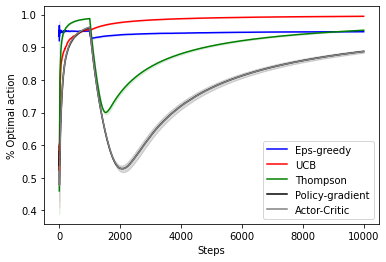

In [45]:
som1 = np.std(perc_opt_act1,axis = 1) / np.sqrt(perc_opt_act1.shape[1])
mean1 = np.mean(perc_opt_act1,axis = 1)

som2 = np.std(perc_opt_act2,axis = 1) / np.sqrt(perc_opt_act2.shape[1])
mean2 = np.mean(perc_opt_act2,axis = 1)

som3 = np.std(perc_opt_act3,axis = 1) / np.sqrt(perc_opt_act3.shape[1])
mean3 = np.mean(perc_opt_act3,axis = 1)

som4 = np.std(perc_opt_act4,axis = 1) / np.sqrt(perc_opt_act4.shape[1])
mean4 = np.mean(perc_opt_act4,axis = 1)

som5 = np.std(perc_opt_act5,axis = 1) / np.sqrt(perc_opt_act5.shape[1])
mean5 = np.mean(perc_opt_act5,axis = 1)

fig, ax = plt.subplots()
ax.plot(range(10000), mean1, 'b')
ax.fill_between(range(10000), (mean1-som1), (mean1+som1), color='b', alpha=.1)
ax.plot(range(10000), mean2,'r')
ax.fill_between(range(10000), (mean2-som2), (mean2+som2), color='r', alpha=.1)
ax.plot(range(10000), mean3, 'g')
ax.fill_between(range(10000), (mean3-som3), (mean3+som3), color='g', alpha=.1)
ax.plot(range(10000), mean4, 'black')
ax.fill_between(range(10000), (mean4-som4), (mean4+som4), color='black', alpha=.1)
ax.plot(range(10000), mean5, 'gray')
ax.fill_between(range(10000), (mean5-som5), (mean5+som5), color='gray', alpha=.1)
ax.set_ylabel('% Optimal action',rotation = 90)
ax.set_xlabel('Steps')
ax.legend(["Eps-greedy", "UCB","Thompson", "Policy-gradient", "Actor-Critic" ])
plt.show()

### Test2_Coded Agents

In [51]:
Multinomial_Rewards = {  '2arm_Hard' : [MultinomialReward_NonStationary([1,0],[0.9,0.1], switch_t = 9000),
                                        MultinomialReward_NonStationary([1,0],[0.8,0.2], switch_t = 9000)] ,
                       
                         '2arm_Med'  : [MultinomialReward_NonStationary([1,0],[0.9,0.1], switch_t = 9000),
                                        MultinomialReward_NonStationary([1,0],[0.5,0.5], switch_t = 9000)],
                       
                         '2arm_Easy' : [MultinomialReward_NonStationary([1,0],[0.9,0.1], switch_t = 9000),
                                        MultinomialReward_NonStationary([1,0],[0.1,0.9], switch_t = 9000)]} 

In [52]:
env = SocialMutliArmedBanditEnvironment(Multinomial_Rewards['2arm_Easy'], 10000)

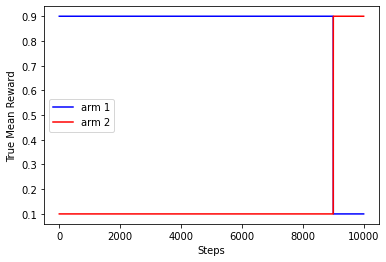

In [53]:
fig, ax = plt.subplots()
ax.plot(range(10000), np.array([0.9] * 9000 + [0.1] * 1000), 'b')
ax.plot(range(10000), np.array([0.1] * 9000 + [0.9] * 1000),'r')

ax.set_ylabel('True Mean Reward',rotation = 90)
ax.set_xlabel('Steps')
ax.legend(["arm 1", "arm 2"])
plt.show()

In [54]:
env.reset()
regret1 = np.zeros((10000,50))
perc_opt_act1 = np.zeros((10000,50))
average_rewards1 = np.zeros((10000,50))

for r in tqdm(range(50)):
    sum_rewards = 0
    opt_act_count = 0
    exp_opt_act = 0.9    
    agent1 = AlwaysBestAgent(environment = env)
    
    for t in range(10000):
        rew , act, _ = agent1.take_action()

        sum_rewards += rew
        
        if t < 9000:
            opt_act_count += int(act == 0)
            regret1[t,r] = (t+1)*exp_opt_act - sum_rewards

        else :
            opt_act_count += int(act == 1)
            exp_opt_act = 0.9
            regret1[t,r] = 9000 * 0.9 + (t+1 - 9000)*exp_opt_act - sum_rewards

        perc_opt_act1[t,r] = opt_act_count / (t+1)
        average_rewards1[t,r] = sum_rewards / (t+1)

    env.reset()

100%|██████████| 50/50 [00:02<00:00, 17.25it/s]


In [55]:
env.reset()
regret2 = np.zeros((10000,50))
perc_opt_act2 = np.zeros((10000,50))
average_rewards2 = np.zeros((10000,50))

for r in tqdm(range(50)):
    exp_opt_act = 0.9
    sum_rewards = 0
    opt_act_count = 0
    
    agent2 = PercentBestAgent(p = 0.8, environment = env)
    # agent2 = UCBBanditAgent('1',env, c = 2, lr = 0.1)
    
    for t in range(10000):
        rew , act, _ = agent2.take_action()
        
        sum_rewards += rew
        
        if t < 9000:
            opt_act_count += int(act == 0)
            regret2[t,r] = (t+1)*exp_opt_act - sum_rewards

        else:
            opt_act_count += int(act == 1)
            exp_opt_act = 0.9
            regret2[t,r] = 9000 * 0.9 + (t+1 - 9000)*exp_opt_act - sum_rewards

        perc_opt_act2[t,r] = opt_act_count / (t+1)
        average_rewards2[t,r] = sum_rewards / (t+1)

    env.reset()

100%|██████████| 50/50 [00:07<00:00,  6.93it/s]


In [56]:
env.reset()
regret3 = np.zeros((10000,50))
perc_opt_act3 = np.zeros((10000,50))
average_rewards3 = np.zeros((10000,50))

for r in tqdm(range(50)):
    sum_rewards = 0
    opt_act_count = 0
    exp_opt_act = 0.9

    agent3 = SecondBestAgent(environment = env)
    
    for t in range(10000):
        rew , act, _ = agent3.take_action()
        
        sum_rewards += rew
        
        if t < 9000:
            opt_act_count += int(act == 0)
            regret3[t,r] = (t+1)*exp_opt_act - sum_rewards

        else :
            opt_act_count += int(act == 1)
            exp_opt_act = 0.9
            regret3[t,r] = 9000 * 0.9 + (t+1 - 9000)*exp_opt_act - sum_rewards

        perc_opt_act3[t,r] = opt_act_count / (t+1)
        average_rewards3[t,r] = sum_rewards / (t+1)

    env.reset()

100%|██████████| 50/50 [00:02<00:00, 17.00it/s]


In [57]:
env.reset()
regret4 = np.zeros((10000,50))
perc_opt_act4 = np.zeros((10000,50))
average_rewards4 = np.zeros((10000,50))

for r in tqdm(range(50)):
    sum_rewards = 0
    opt_act_count = 0
    exp_opt_act = 0.9
    
    agent4 = AlwaysWorstAgent(environment = env)
    
    for t in range(10000):
        rew , act, _ = agent4.take_action()
        sum_rewards += rew
        
        if t < 9000:
            opt_act_count += int(act == 0)
            regret4[t,r] = (t+1)*exp_opt_act - sum_rewards
        
        else :
            opt_act_count += int(act == 1)
            exp_opt_act = 0.9
            regret4[t,r] = 9000 * 0.9 + (t+1 - 9000)*exp_opt_act - sum_rewards

        perc_opt_act4[t,r] = opt_act_count / (t+1)
        average_rewards4[t,r] = sum_rewards / (t+1)

    env.reset()

100%|██████████| 50/50 [00:02<00:00, 16.96it/s]


In [58]:

env.reset()
regret5 = np.zeros((10000,50))
perc_opt_act5 = np.zeros((10000,50))
average_rewards5 = np.zeros((10000,50))

for r in tqdm(range(50)):
    exp_opt_act = 0.9
    sum_rewards = 0
    opt_act_count = 0

    agent5 = AlwaysRandomAgent(environment = env)

    # agent4 = gradientAgent('1',env, alpha = 0.1, Baseline_lr = 0.01)
    for t in range(10000):
        rew , act, _ = agent5.take_action()
        
        sum_rewards += rew
        
        if t < 9000:
            opt_act_count += int(act == 0)
            regret5[t,r] = (t+1)*exp_opt_act - sum_rewards
        
        else :
            opt_act_count += int(act == 1)
            exp_opt_act = 0.9
            regret5[t,r] = 9000 * 0.9 + (t+1 - 9000)*exp_opt_act - sum_rewards

        perc_opt_act5[t,r] = opt_act_count / (t+1)
        average_rewards5[t,r] = sum_rewards / (t+1)

    env.reset()

100%|██████████| 50/50 [00:12<00:00,  3.90it/s]


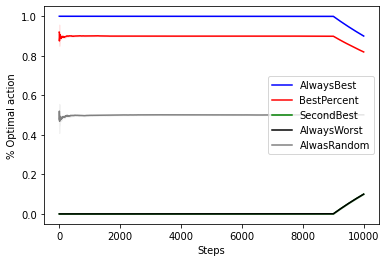

In [59]:
som1 = np.std(perc_opt_act1,axis = 1) / np.sqrt(perc_opt_act1.shape[1])
mean1 = np.mean(perc_opt_act1,axis = 1)

som2 = np.std(perc_opt_act2,axis = 1) / np.sqrt(perc_opt_act2.shape[1])
mean2 = np.mean(perc_opt_act2,axis = 1)

som3 = np.std(perc_opt_act3,axis = 1) / np.sqrt(perc_opt_act3.shape[1])
mean3 = np.mean(perc_opt_act3,axis = 1)

som4 = np.std(perc_opt_act4,axis = 1) / np.sqrt(perc_opt_act4.shape[1])
mean4 = np.mean(perc_opt_act4,axis = 1)

som5 = np.std(perc_opt_act5,axis = 1) / np.sqrt(perc_opt_act5.shape[1])
mean5 = np.mean(perc_opt_act5,axis = 1)

fig, ax = plt.subplots()
ax.plot(range(10000), mean1, 'b')
ax.fill_between(range(10000), (mean1-som1), (mean1+som1), color='b', alpha=.1)
ax.plot(range(10000), mean2,'r')
ax.fill_between(range(10000), (mean2-som2), (mean2+som2), color='r', alpha=.1)
ax.plot(range(10000), mean3, 'g')
ax.fill_between(range(10000), (mean3-som3), (mean3+som3), color='g', alpha=.1)
ax.plot(range(10000), mean4, 'black')
ax.fill_between(range(10000), (mean4-som4), (mean4+som4), color='black', alpha=.1)
ax.plot(range(10000), mean5, 'gray')
ax.fill_between(range(10000), (mean5-som5), (mean5+som5), color='gray', alpha=.1)
ax.set_ylabel('% Optimal action',rotation = 90)
ax.set_xlabel('Steps')
ax.legend(["AlwaysBest", "BestPercent","SecondBest", "AlwaysWorst", "AlwasRandom" ])
plt.show()

## Social Learning Implementation

Agent id -1 is equivalant to None

In [56]:
class MostFrequentSocialStrategy():
    def __init__(self):
        """
        """
        pass 
        
    def select_action(self, env, selecting_policy):
        agent_id = np.random.choice(len(selecting_policy),p = selecting_policy)    
        return env.agents_last_choice[agent_id], agent_id

In [77]:
class PreferenceBasedSocialAgent(AgentBase):

    def __init__(self, ilm, lr = 0.1, id = None, env = None):
        """
        ilm: 
        lr:
        id: 
        env: an environment object
        """
        super(PreferenceBasedSocialAgent, self).__init__(env, id = id)
        self.ilm = ilm 
        self.lr = lr
        self.t = 0 #trial
        self.total_mean_reward = 0 
        self.selecting_history = []
        self.actions = []

        if self.environment is not None:
            self.n = len(self.environment.agents_last_choice) # number of agents
            self.k = self.environment.n_actions() # number of actions
            self.preferences = np.zeros(self.n)+0.0001
            self.lrs = np.ones(self.n)*lr
            self.social_information = np.zeros((self.n,self.k))
            # uniform initialization, (Others can be done, ourself 1 the others zero)
            self.selecting_policy = np.ones(self.n)/self.n
            self.preferences_history  = {i:[] for i in range(self.n)}

    def set_environment(self, env):
        self.environment = env 
        self.n = len(self.environment.agents_last_choice) # number of agents
        self.k = self.environment.n_actions() # number of actions
        self.preferences = np.zeros(self.n)+0.0001
        self.lrs = np.ones(self.n)*self.lr
        self.social_information = np.zeros((self.n,self.k))
        # uniform initialization, (Others can be done, ourself 1 the others zero)
        self.selecting_policy = np.ones(self.n)/self.n
        self.preferences_history  = {i:[] for i in range(self.n)}

    def update(self, u, action, agent_id, ind_mode):
        self.t += 1
        self.total_mean_reward += (u - self.total_mean_reward)/self.t
        same = []
        for i in range(self.n):
            self.social_information[i][self.environment.agents_last_choice[i]] += 1
            if self.environment.agents_last_choice[i]== action:
                same.append(i)
        if self.id not in same and self.ilm.select_action() == action:
            same.append(self.id)
        
        self.preferences -= self.lrs *  (u - self.total_mean_reward) * self.selecting_policy
        for index in same:
            self.preferences[index] += self.lrs * (u - self.total_mean_reward)
        # self.preference = np.round(self.preference,2)
        # d = np.sum(np.exp(self.preference))
        # mask = np.ones(len(self.preference))*alpha
        # self.preference = self.preference - mask * (Ri - self.mean_reward) * np.exp(self.preference)/d
        # for index in same:
        #     self.preference[index] = self.preference[index] + alpha * (Ri - self.mean_reward)

        p = np.exp(self.preferences - np.max(self.preferences))
        self.selecting_policy = p / p.sum(axis=0)
        for i in range(self.n):
            self.preferences_history[i].append(self.selecting_policy[i])
        # p =  np.round(np.exp(np.round(self.preferences,2)),2)
        # self.selecting_policy = p/np.sum(p)
        # for j in range(len(p)):
        #     if np.isnan(p[j]):
        #         p[j] = 1
        if agent_id == self.id or ind_mode:
            self.ilm.update(action, u)

    def select_action(self, sls, ind_mode):
        action, agent_id = sls.select_action(self.environment, self.selecting_policy) 
        if agent_id == self.id or ind_mode:
            self.selecting_history.append(self.id) #?????????????????????????????????????????????????????/
            # choose individual learning method
            action = self.ilm.select_action()
        else:
            print("*")
            self.selecting_history.append(agent_id)

        return action, agent_id

    def take_action(self, sls, ind_mode = False):
        if self.environment is None:
            raise("env is not defined,")
        action, agent_id = self.select_action(sls, ind_mode)
        obs, r, d, i = self.environment.step(action, self.id)
        u = self.utility_function(r)
        self.update(u,action, agent_id, ind_mode)
        self.actions.append(action)        
        return r,action, u

    def get_actions(self):
        return self.actions

In [67]:
class MetaSocialLearnerAgent(AgentBase):

    def __init__(self, slm, sls, env = None):
        super(MetaSocialLearnerAgent, self).__init__(environment = env) 
        self.slm = slm
        self.sls = sls
        self.ind_mode = False 

    def set_environment(self, env):
        self.environment = env
        self.slm.environment = env
        
    def update(self, u, action):
        # Novelty/Surprise
        # Volatileness
        # Uncertainty
        return 
    
    def select_sls(self):
        pass 
    
    def select_slm(self):
        pass

    def take_action(self):
        # Based on Novelty/Surprise, Volatileness, Uncertainty
        # Select social learning strategy
        # Select social learning method using Free energy or predefined rules
        if self.environment is None: 
            raise("environment is not defined")
        r, action, u = self.slm.take_action(self.sls, self.ind_mode)
        self.update(u,action)
        
        return r, action, u

In [59]:
class agents_population():
    def __init__(self, ):
        """
        should return a list of agent objects
        """
        pass


In [60]:
class environemnt_class():
    def __init__(self):
        """
        should return a list of environment objects
        """
        pass

In [61]:
class SocialBanditLearning():
    def __init__(self, pop_agents, env_class, n_trials, n_reps):
        """
        pop_agents: a list of agent obejcts
        env_class: a list of environment objects
        n_reps: an integer, number of repetiotions
        n_trials: an integer, number of trials 
        """
        self.pop_agents = pop_agents
        self.env_class = env_class
        self.n_trials = n_trials 
        self.n_reps = n_reps 
        self.n_agents = len(pop_agents)
        self.n_envs = len(env_class)

        self.best_actions, self.best_exp_u = self.calculate_bests()    
        
        self.action_history = np.zeros((self.n_envs, self.n_agents, self.n_reps, self.n_trials))
        self.utility_history = np.zeros((self.n_envs, self.n_agents, self.n_reps, self.n_trials)) 
        
        self.regret = np.zeros((self.n_envs, self.n_agents, self.n_reps, self.n_trials))
        self.perc_opt_act = np.zeros((self.n_envs, self.n_agents, self.n_reps, self.n_trials))
        self.average_utils = np.zeros((self.n_envs, self.n_agents, self.n_reps, self.n_trials))
        
    def best_max(self, env, agent): 
        EU = np.array([agent.utility_function(r.mean) for r in env.arms_rewards])
        max_ind = np.random.choice(np.flatnonzero(EU == EU.max()))
        return max_ind, EU.max() 

    def calculate_bests(self):
        best_actions = np.zeros((self.n_envs, self.n_agents))
        best_exp_u = np.zeros((self.n_envs, self.n_agents))
        for i, env in enumerate(self.env_class):
            for j, agent in enumerate(self.pop_agents):
                best_actions[i,j], best_exp_u[i,j] = self.best_max(env, agent)
        
        return best_actions, best_exp_u

    def run(self):
        for i, env in enumerate(self.env_class):
            env.reset()

            for r in range(self.n_reps):
                sum_utils = np.zeros((self.n_agents))
    
                for t in range(self.n_trials):
                    
                    for j, agent in enumerate(self.pop_agents):
                        agent.set_environment(env)
                        rew, act, u = agent.take_action()
                        self.action_history[i,j,r,t] = act
                        self.utility_history[i,j,r,t] = u
                        sum_utils[j] += u
                    
                    self.perc_opt_act[i,:,r,t] += (self.action_history[i,:,r,t] == self.best_actions[i,:]).astype(int) / (t+1)
                    self.regret[i,:,r,t] = (t+1)*self.best_exp_u[i,:] - sum_utils
                    self.average_utils[i,:,r,t] = sum_utils / (t+1)
                    
                env.reset()
    
    def regret_visulization(self):
        """
        compare to individual learning
        """

        pass

## Test II

### Test ilm of msl

In [63]:
Multinomial_Rewards = {  '2arm_Hard' : [MultinomialReward_NonStationary([1,0],[0.9,0.1], switch_t = 1000),
                                        MultinomialReward_NonStationary([1,0],[0.8,0.2], switch_t = 1000)] ,
                       
                         '2arm_Med'  : [MultinomialReward_NonStationary([1,0],[0.9,0.1], switch_t = 1000),
                                        MultinomialReward_NonStationary([1,0],[0.5,0.5], switch_t = 1000)],
                       
                         '2arm_Easy' : [MultinomialReward_NonStationary([1,0],[0.9,0.1], switch_t = 1000),
                                        MultinomialReward_NonStationary([1,0],[0.1,0.9], switch_t = 1000)]} 

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(10000), np.array([0.9] * 1000 + [0.1] * 9000), 'b')
ax.plot(range(10000), np.array([0.1] * 1000 + [0.9] * 9000),'r')

ax.set_ylabel('True Mean Reward',rotation = 90)
ax.set_xlabel('Steps')
ax.legend(["arm 1", "arm 2"])
plt.show()

In [65]:
env = SocialMutliArmedBanditEnvironment(Multinomial_Rewards['2arm_Easy'], 10000)

In [66]:
env.reset()
regret1 = np.zeros((10000,50))
perc_opt_act1 = np.zeros((10000,50))
average_rewards1 = np.zeros((10000,50))

for r in tqdm(range(50)):
    sum_rewards = 0
    opt_act_count = 0
    exp_opt_act = 0.9    
    
    ilm1 = EpsilonGreedyAgent(environment = env, epsilon = 0.1, lr = 0.1)
    sls1 = MostFrequentSocialStrategy()
    slm1 = PreferenceBasedSocialAgent(env, 0, 0.1, ilm1)
    msl1 = MetaSocialLearnerAgent(env, slm1, sls1)

    for t in range(10000):
        rew , act, _ = msl1.take_action()

        sum_rewards += rew
        
        if t < 1000:
            opt_act_count += int(act == 0)
            regret1[t,r] = (t+1)*exp_opt_act - sum_rewards

        else :
            opt_act_count += int(act == 1)
            exp_opt_act = 0.9
            regret1[t,r] = 1000 * 0.9 + (t+1 - 1000)*exp_opt_act - sum_rewards

        perc_opt_act1[t,r] = opt_act_count / (t+1)
        average_rewards1[t,r] = sum_rewards / (t+1)

    env.reset()

100%|██████████| 50/50 [00:47<00:00,  1.06it/s]


In [67]:
env.reset()
regret2 = np.zeros((10000,50))
perc_opt_act2 = np.zeros((10000,50))
average_rewards2 = np.zeros((10000,50))

for r in tqdm(range(50)):
    exp_opt_act = 0.9
    sum_rewards = 0
    opt_act_count = 0
    
    ilm2 = UCBAgent(environment = env, c =2, lr = 0.1)
    sls2 = MostFrequentSocialStrategy()
    slm2 = PreferenceBasedSocialAgent(env, 0, 0.1, ilm2)
    msl2 = MetaSocialLearnerAgent(env, slm2, sls2)

    # agent2 = UCBBanditAgent('1',env, c = 2, lr = 0.1)
    
    for t in range(10000):
        rew , act, _ = msl2.take_action()
        
        sum_rewards += rew
        
        if t < 1000:
            opt_act_count += int(act == 0)
            regret2[t,r] = (t+1)*exp_opt_act - sum_rewards

        else:
            opt_act_count += int(act == 1)
            exp_opt_act = 0.9
            regret2[t,r] = 1000 * 0.9 + (t+1 - 1000)*exp_opt_act - sum_rewards

        perc_opt_act2[t,r] = opt_act_count / (t+1)
        average_rewards2[t,r] = sum_rewards / (t+1)

    env.reset()

100%|██████████| 50/50 [01:15<00:00,  1.51s/it]


In [68]:
env.reset()
regret3 = np.zeros((10000,50))
perc_opt_act3 = np.zeros((10000,50))
average_rewards3 = np.zeros((10000,50))

for r in tqdm(range(50)):
    sum_rewards = 0
    opt_act_count = 0
    exp_opt_act = 0.9

    ilm3 = ThompsonSamplingAgent(environment = env)
    sls3 = MostFrequentSocialStrategy()
    slm3 = PreferenceBasedSocialAgent(env, 0, 0.1, ilm3)
    msl3 = MetaSocialLearnerAgent(env, slm3, sls3)
    
    for t in range(10000):
        rew , act, _ = msl3.take_action()
        
        sum_rewards += rew
        
        if t < 1000:
            opt_act_count += int(act == 0)
            regret3[t,r] = (t+1)*exp_opt_act - sum_rewards

        else :
            opt_act_count += int(act == 1)
            exp_opt_act = 0.9
            regret3[t,r] = 1000 * 0.9 + (t+1 - 1000)*exp_opt_act - sum_rewards

        perc_opt_act3[t,r] = opt_act_count / (t+1)
        average_rewards3[t,r] = sum_rewards / (t+1)

    env.reset()

100%|██████████| 50/50 [01:09<00:00,  1.38s/it]


In [69]:
env.reset()
regret4 = np.zeros((10000,50))
perc_opt_act4 = np.zeros((10000,50))
average_rewards4 = np.zeros((10000,50))

for r in tqdm(range(50)):
    sum_rewards = 0
    opt_act_count = 0
    exp_opt_act = 0.9
    
    ilm4 = GradientBanditAgent(environment = env)
    sls4 = MostFrequentSocialStrategy()
    slm4 = PreferenceBasedSocialAgent(env, 0, 0.1, ilm4)
    msl4 = MetaSocialLearnerAgent(env, slm4, sls4)  
    
    for t in range(10000):
        rew , act, _ = msl4.take_action()
        sum_rewards += rew
        
        if t < 1000:
            opt_act_count += int(act == 0)
            regret4[t,r] = (t+1)*exp_opt_act - sum_rewards
        
        else :
            opt_act_count += int(act == 1)
            exp_opt_act = 0.9
            regret4[t,r] = 1000 * 0.9 + (t+1 - 1000)*exp_opt_act - sum_rewards

        perc_opt_act4[t,r] = opt_act_count / (t+1)
        average_rewards4[t,r] = sum_rewards / (t+1)

    env.reset()

100%|██████████| 50/50 [01:07<00:00,  1.35s/it]


In [70]:

env.reset()
regret5 = np.zeros((10000,50))
perc_opt_act5 = np.zeros((10000,50))
average_rewards5 = np.zeros((10000,50))

for r in tqdm(range(50)):
    exp_opt_act = 0.9
    sum_rewards = 0
    opt_act_count = 0

    ilm5 = ActorCriticAgent(environment = env, lr = 0.1)
    sls5 = MostFrequentSocialStrategy()
    slm5 = PreferenceBasedSocialAgent(env, 0, 0.1, ilm5)
    msl5 = MetaSocialLearnerAgent(env, slm5, sls5)

    # agent4 = gradientAgent('1',env, alpha = 0.1, Baseline_lr = 0.01)
    for t in range(10000):
        rew , act, _ = msl5.take_action()
        
        sum_rewards += rew
        
        if t < 1000:
            opt_act_count += int(act == 0)
            regret5[t,r] = (t+1)*exp_opt_act - sum_rewards
        
        else :
            opt_act_count += int(act == 1)
            exp_opt_act = 0.9
            regret5[t,r] = 1000 * 0.9 + (t+1 - 1000)*exp_opt_act - sum_rewards

        perc_opt_act5[t,r] = opt_act_count / (t+1)
        average_rewards5[t,r] = sum_rewards / (t+1)

    env.reset()

100%|██████████| 50/50 [01:09<00:00,  1.39s/it]


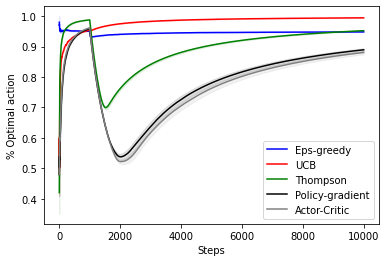

In [71]:
som1 = np.std(perc_opt_act1,axis = 1) / np.sqrt(perc_opt_act1.shape[1])
mean1 = np.mean(perc_opt_act1,axis = 1)

som2 = np.std(perc_opt_act2,axis = 1) / np.sqrt(perc_opt_act2.shape[1])
mean2 = np.mean(perc_opt_act2,axis = 1)

som3 = np.std(perc_opt_act3,axis = 1) / np.sqrt(perc_opt_act3.shape[1])
mean3 = np.mean(perc_opt_act3,axis = 1)

som4 = np.std(perc_opt_act4,axis = 1) / np.sqrt(perc_opt_act4.shape[1])
mean4 = np.mean(perc_opt_act4,axis = 1)

som5 = np.std(perc_opt_act5,axis = 1) / np.sqrt(perc_opt_act5.shape[1])
mean5 = np.mean(perc_opt_act5,axis = 1)

fig, ax = plt.subplots()
ax.plot(range(10000), mean1, 'b')
ax.fill_between(range(10000), (mean1-som1), (mean1+som1), color='b', alpha=.1)
ax.plot(range(10000), mean2,'r')
ax.fill_between(range(10000), (mean2-som2), (mean2+som2), color='r', alpha=.1)
ax.plot(range(10000), mean3, 'g')
ax.fill_between(range(10000), (mean3-som3), (mean3+som3), color='g', alpha=.1)
ax.plot(range(10000), mean4, 'black')
ax.fill_between(range(10000), (mean4-som4), (mean4+som4), color='black', alpha=.1)
ax.plot(range(10000), mean5, 'gray')
ax.fill_between(range(10000), (mean5-som5), (mean5+som5), color='gray', alpha=.1)
ax.set_ylabel('% Optimal action',rotation = 90)
ax.set_xlabel('Steps')
ax.legend(["Eps-greedy", "UCB","Thompson", "Policy-gradient", "Actor-Critic" ])
plt.show()

### Test slm

In [73]:
pop_agents = []
for i in range(10):
    pop_agents.append(AlwaysRandomAgent())

pop_agents.append(ThompsonSamplingAgent())

ilm1 = EpsilonGreedyAgent(epsilon = 0.1, lr = 0.1)
sls1 = MostFrequentSocialStrategy()
slm1 = PreferenceBasedSocialAgent(ilm1, 0.1)
msl1 = MetaSocialLearnerAgent(slm1, sls1)
pop_agents.append(msl1)

In [74]:
env_class = []
rewards = [(i-100)/10 for i in range(200)]
for k in [10,100]:
    reward_means = np.random.choice(rewards,k, replace=False)
    reward_means = np.sort(reward_means)
    reward_var = np.ones(k)
    Reward = [GaussianReward(reward_means[i], reward_var[i]) for i in range(k)]
    env = SocialMutliArmedBanditEnvironment(Reward, 10000)
    env_class.append(env)

In [75]:
sbl = SocialBanditLearning(pop_agents, env_class, 1000, 30)

In [76]:
sbl.run()

AttributeError: ignored